In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define Domain
# Space
Xpts = int(1e2)  # Grid Points
X0, Xf = 0, 100  # Domain
Xlng = Xf-X0
dx = Xlng/Xpts  # Grid Size
x = np.arange(X0, Xf, dx)  # Spatial Domain

# Time
dt = 1e-3  # Time Step Size
T0, Tf = 0, 10  # Domain
Tlng = Tf-T0
Tpts = int(Tlng/dt)  # Time Steps
t = np.linspace(T0, Tf, num=Tpts, endpoint=False)

# Numerical Parameters
xx, tt = np.meshgrid(x,t, sparse=False, indexing='xy') # Spatial-Temporal Domain
lmbd = dt / dx # 1e2/2.5e2 = .4
n_0 = 3 / (4 * np.pi)
Gamma_0 = 1 # input("Enter Gamma_0: ")
kappa_0 = 1 # input("Enter kappa_0: ")
beta = 1

# Correlation Parameters
k_fft_norm = 2*np.pi/(Xpts*dx)
k = k_fft_norm * np.linspace(-Xpts/2, Xpts/2-1,Xpts)  # Fourier Domain
x3 = np.linspace(-Xlng, 2*Xlng, 3*Xpts-2)  # Correlation Domain

print(lmbd)

0.001


In [2]:
def memoryPDE(u_IC):
    u = np.zeros((2,Tpts,Xpts))
    u[:,0] = np.copy(u_IC)
    Fu = np.zeros((2,Tpts,Xpts))
    return u, Fu

In [3]:
# Initial Conditions
disp_freq = 3 * 2 * np.pi / Xlng
n_IC = n_0*np.ones(Xpts) + .1*np.sin(disp_freq * x)
v_IC = 1+.1 * np.sin(disp_freq * x)
# v_IC = np.zeros(Xpts)
# v_IC[0:int(Xpts/2)] = 1 
# n_IC = n_0 * np.ones(Xpts) + .0001 * (np.random.rand(Xpts))
# v_IC = .0001 * (np.random.rand(Xpts))

# Memory Allocation
n, Fn = memoryPDE(n_IC)
v, Fv = memoryPDE(v_IC)
phi = np.zeros((2,Tpts,Xpts))
f_corr = np.zeros((Tpts, Xpts))
rhs = np.zeros((2,Tpts,Xpts))
godunov_flux = np.zeros((2,2,Tpts,Xpts)) #eq,c,t,x
flux_n = np.zeros((2,Tpts,Xpts)) #eq,c,t,x
flux_v = np.zeros((2,Tpts,Xpts)) #eq,c,t,x

In [4]:
# =============== #
# Solve Functions #
# =============== #
def solve_phic(cor, cur_time, un, uphi):
    uphi_c_cur = uphi[cor,cur_time]
    un_c_cur = un[cor,cur_time]
    A = np.zeros(Xpts)
    # Define b
    b = 3 - 4 * np.pi * dx * dx * un_c_cur
    b = b - np.mean(b)
    # First sweep
    A[0] = -0.5
    b[0] = -0.5 * b[0]
    for ii in range(1, Xpts):
        A[ii] = -1 / (2 + A[ii - 1])
        b[ii] = (b[ii - 1] - b[ii]) / (2 + A[ii - 1])
    # Second sweep
    uphi_c_cur[0] = b[Xpts - 1] - b[Xpts - 2]
    for ii in range(1, Xpts - 1):
        uphi_c_cur[ii] = (b[ii - 1] - uphi_c_cur[ii - 1]) / A[ii - 1]
    return uphi_c_cur

def nonisotropic_correlations(unc, cur_time, n3, x, x3,f_corr):
    conc = unc / n_0
    Gamma = Gamma_0 * conc ** (1 / 3)
    kappa = kappa_0 * conc ** (1 / 6)

    n3[0:N] = unc[cur_time]
    n3[N:2 * N] = unc[cur_time]
    n3[2 * N:3 * N] = unc[cur_time]
    for jj in range(N):
        rho_int = - 2 * np.pi * Gamma[jj] * np.exp(- kappa[jj] * np.abs(x3 - x[jj])) / kappa[jj]
        f_corr[jj] = dx * np.sum(n3 * rho_int)
    return f_corr

def fft_meanfield(k,nctt,Gamma, kappa):
    delta_n = nctt - n_0
    def dcf(k, Gamma, kappa):
        return 4 * np.pi * Gamma / (k ** 2 + kappa ** 2)

    dcfunc = dcf(k,Gamma,kappa)
    fhat = np.fft.fftshift(np.fft.fft(delta_n))
    conv = fhat * dcfunc
    conv = np.fft.ifft(np.fft.ifftshift(conv))
    conv = np.real(conv)
    return conv

def fft_meyerf(k,nc,Gamma, kappa, beta):
    delta_n = nc - n_0

    # f_fft_norm = 1 / dx
    # k_fft_norm = 2 * np.pi / (N * dx)

    # Parameters
    Nr = int(1e3)
    rmax = 100  # TODO: Change per loop
    r = np.linspace(0, rmax, Nr)

    dcf = np.exp(-beta * r ** 2)
    dcf_fft = np.fft.fftshift(np.fft.fft(dcf))
    dcf_fft_ex = (np.pi / beta) ** (3 / 2) * np.exp(- k ** 2 / (4 * beta))

    n_hat = np.fft.fftshift(np.fft.fft(delta_n))
    conv = n_hat * dcf_fft
    conv = np.fft.ifft(np.fft.ifftshift(conv))
    conv = np.real(conv)
    return conv

def godunov(uctt, Fuctt):
    ugodunovctt = np.zeros((Xpts))
    for ii in range(Xpts): # Iterate over spacial values
        if uctt[ii-1] > uctt[ii]: 
            ugodunovctt[ii] = np.maximum(Fuctt[ii-1], Fuctt[ii])
        elif uctt[ii-1] < uctt[ii]:
            ugodunovctt[ii] = np.minimum(Fuctt[ii-1], Fuctt[ii])
        else:
            ugodunovctt[ii] = 0.0
        return ugodunovctt
    
def jacobian(uFn, uFv, un, uv):
    duFn = (np.roll(uFn,-1) - np.roll(uFn,1))/2
    duFv = (np.roll(uFv,-1) - np.roll(uFv,1))/2
    dun = (np.roll(un,-1) - np.roll(un,1))/2
    duv = (np.roll(uv,-1) - np.roll(uv,1))/2
        
    udFndn = duFn / dun
    udFvdn = duFn / dun
    udFndv = duFn / duv
    udFvdv = duFv / duv
    
    jacobian = np.zeros((N,2,2))
    for ii in range(N):
        jacobian[ii] = np.array([[udFndn[ii],udFndv[ii]],[udFvdn[ii],udFvdv[ii]]])   
    return jacobian
    

In [5]:
# ===== #
# Solve #
# ===== #
st = time.time()
for c in range(2): # Iterate through correlations
    for tt in range(1,Tpts): # Iterate Time
        for ii in range(Xpts):
            Fn[c,tt,ii] = n[c,tt-1,ii]*v[c,tt-1,ii]
            Fv[c,tt,ii] = .5*v[c,tt-1,ii]*v[c,tt-1,ii]+np.log(n[c,tt-1,ii])

        vec = np.stack((n,v))
        vec_L = np.roll(vec, 1,axis=-1)
        vec_flux = np.stack((Fn, Fv))
        vec_flux_L = np.roll(vec_flux, 1,axis=-1)

        for eq in range(2): # Iterate over system
            for ii in range(Xpts): # Iterate over spacial values
                if vec_L[eq,c,tt,ii] > vec[eq,c,tt,ii]:
                    godunov_flux[eq,c,tt,ii] = np.maximum(vec_flux_L[eq,c,tt,ii], vec_flux[eq,c,tt,ii])
                elif vec_L[eq,c,tt,ii] < vec[eq,c,tt,ii]:
                    godunov_flux[eq,c,tt,ii] = np.minimum(vec_flux_L[eq,c,tt,ii], vec_flux[eq,c,tt,ii])
                else:
                    godunov_flux[eq,c,tt,ii] = 0.0

#         flux_n[c,tt] = godunov(n[c,tt],Fn[c,tt])
#         flux_v[c,tt] = godunov(v[c,tt],Fv[c,tt])

#         phi[c,tt] = solve_phic(c,tt,n,phi)
#         rhs[c,tt] = -Gamma_0*(phi[c,tt] - np.roll(phi[c,tt],1))/dx
#         if c == 0:
#             # f_corr = anisotropic_correlations(n,n3,x,x3,f_corr)
#             f_corr[tt] = fft_meanfield(k,n[c,tt],Gamma_0,kappa_0)
#             rhs[c,tt] += -(f_corr[tt] - np.roll(f_corr[tt],1))/dx

        n[c,tt,0] = n[c,tt-1,0]-lmbd*(Fn[c,tt-1,0]-Fn[c,tt-1,Xpts-1])
        v[c,tt,0] = v[c,tt-1,0]-lmbd*(Fv[c,tt-1,0]-Fv[c,tt-1,Xpts-1])+dt*rhs[c,tt,0]
        for ii in range(1,Xpts):
            n[c,tt,ii] = n[c,tt-1,ii]-lmbd*(Fn[c,tt-1,ii]-Fn[c,tt-1,ii-1])
            v[c,tt,ii] = v[c,tt-1,ii]-lmbd*(Fv[c,tt-1,ii]-Fv[c,tt-1,ii-1])+dt*rhs[c,tt,ii]
        
        # n[c,tt,0] = n[c,tt-1,0]-lmbd*(flux_n[c,tt-1,0]-flux_n[c,tt-1,Xpts-1])
        # v[c,tt,0] = v[c,tt-1,0]-lmbd*(flux_v[c,tt-1,0]-flux_v[c,tt-1,Xpts-1])+rhs[c,tt,0]
        # for ii in range(1,Xpts):
        #     n[c,tt,ii] = n[c,tt-1,ii]-lmbd*(flux_n[c,tt-1,ii]-flux_n[c,tt-1,ii-1])
        #     v[c,tt,ii] = v[c,tt-1,ii]-lmbd*(flux_v[c,tt-1,ii]-flux_v[c,tt-1,ii-1])+rhs[c,tt,ii]

        if  tt % 50 == 0:
            print(tt)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9600
9650
9700
9750
9800
9850
9900
9950
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [6]:
# ============== #
# Plot Functions #
# ============== #

snaps = 20

def plot(ux, uc):
    fig = plt.figure(figsize=(15,15))
    plt.title('Γ = ' + str(Gamma_0) + ', κ = ' + str(kappa_0))
    for tt in range(Tpts):
        if tt % (Tpts / snaps) == 0:
            plt.plot(ux, uc[tt], label=str(tt/snaps))
    plt.legend()
    plt.show(block=False)

def cmap(ux, ut, uc): 
    fig = plt.figure(figsize=(15,15))
#    color_map = plt.contourf(ux, ut, u[c,:])
    color_map = plt.imshow(uc, cmap='viridis', origin='lower', extent=(X0,Xf,T0,Tf), aspect='auto')
    plt.title('Γ = ' + str(Gamma_0) + ', κ = ' + str(kappa_0))
    plt.colorbar()
    plt.ylabel("Time")
    plt.xlabel("Space")
    plt.show(block=False)    

def calculate_2dft(uc):
    fft = np.fft.ifftshift(uc-np.mean(uc[:]))
    fft = np.fft.fft2(fft)
    return np.abs(np.fft.fftshift(fft))

def disp_rel_cmap(ux, ut, uc):
    fft = calculate_2dft(uc)
    fig = plt.figure(figsize=(15,15))
    color_map = plt.contourf(ux, ut, fft)
    color_map = plt.imshow(fft, cmap='viridis', origin='lower', extent=(X0,Xf,T0,Tf), aspect='auto')
#    plt.title('Γ = ' + str(Gamma[ii]) + ', κ = ' + str(kappa[jj]))
    plt.title('Γ = ' + str(Gamma_0) + ', κ = ' + str(kappa_0))
    plt.colorbar()
    plt.ylabel("Time - Frequency")
    plt.xlabel("Space - Frequency")
    plt.show(block=False)
        
def plot3D():
    fig = plt.figure()
    

0.001


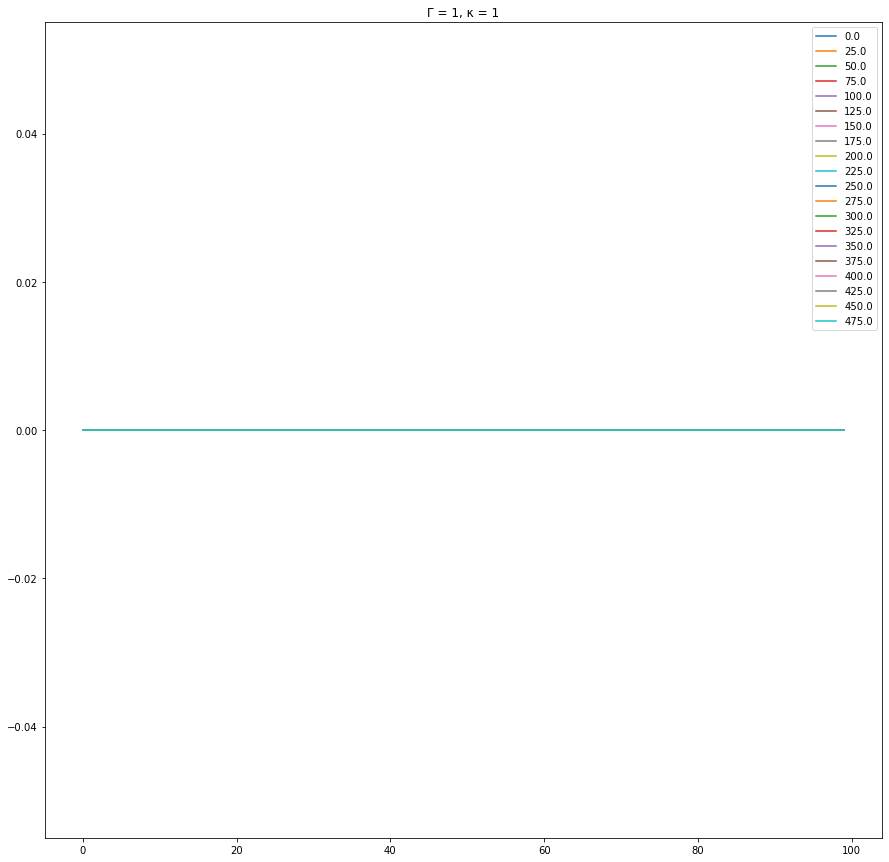

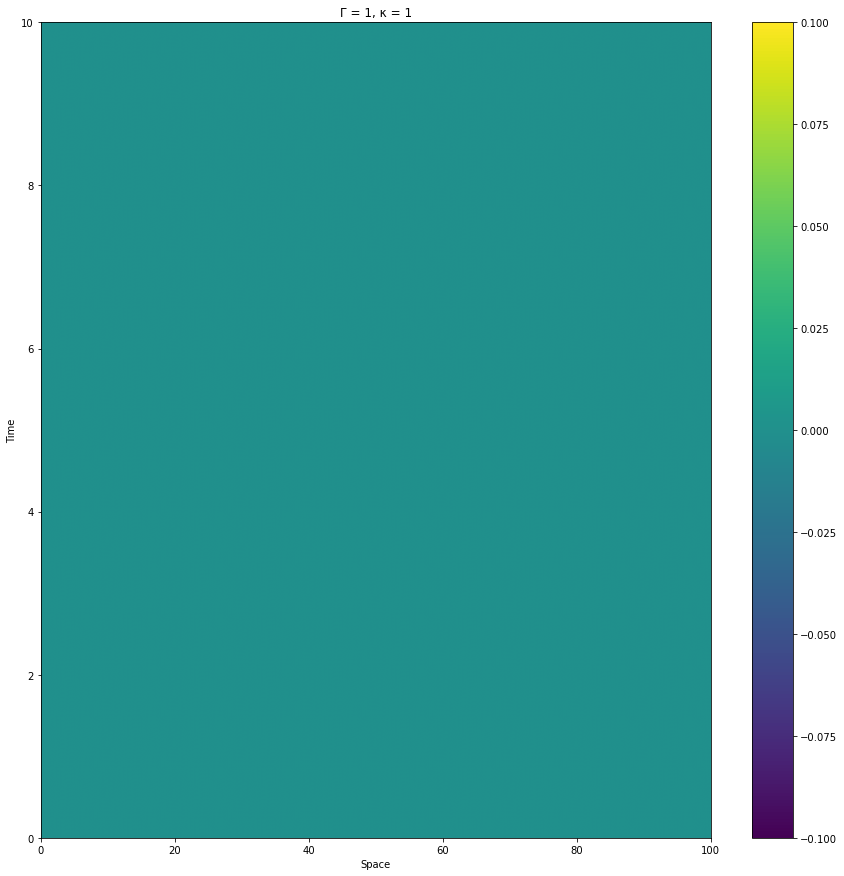

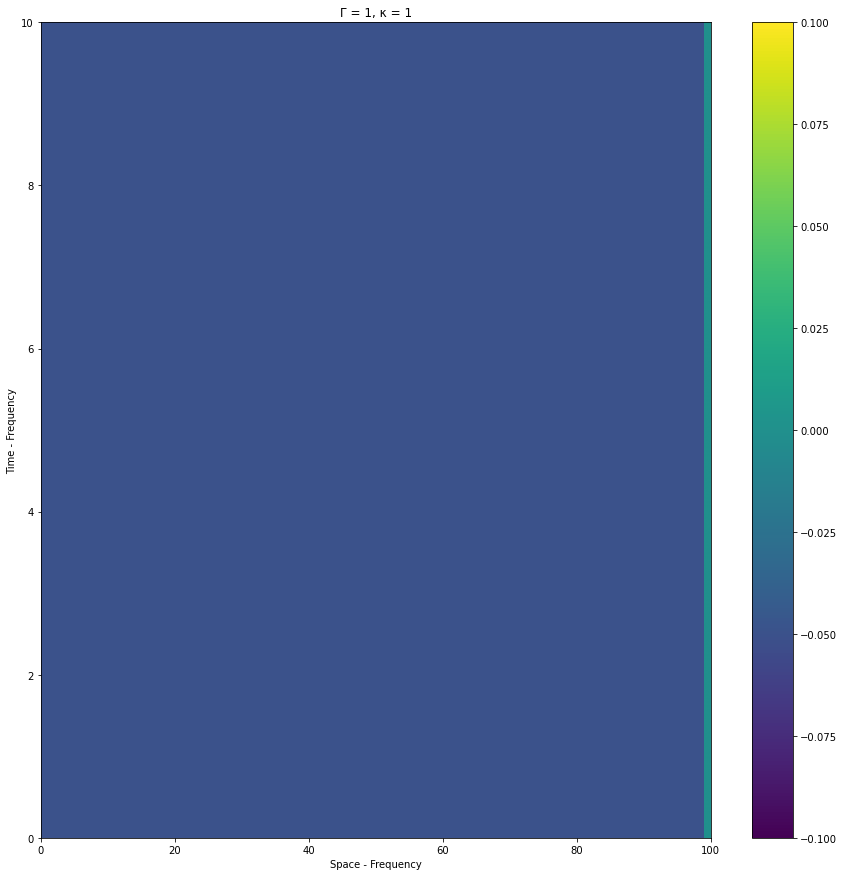

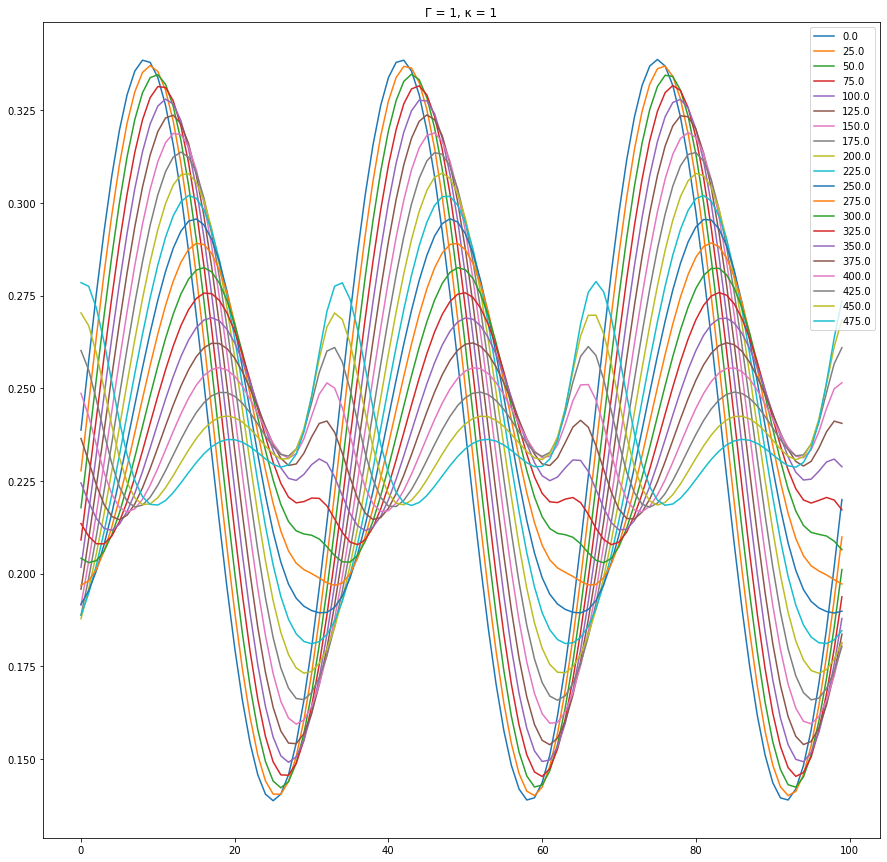

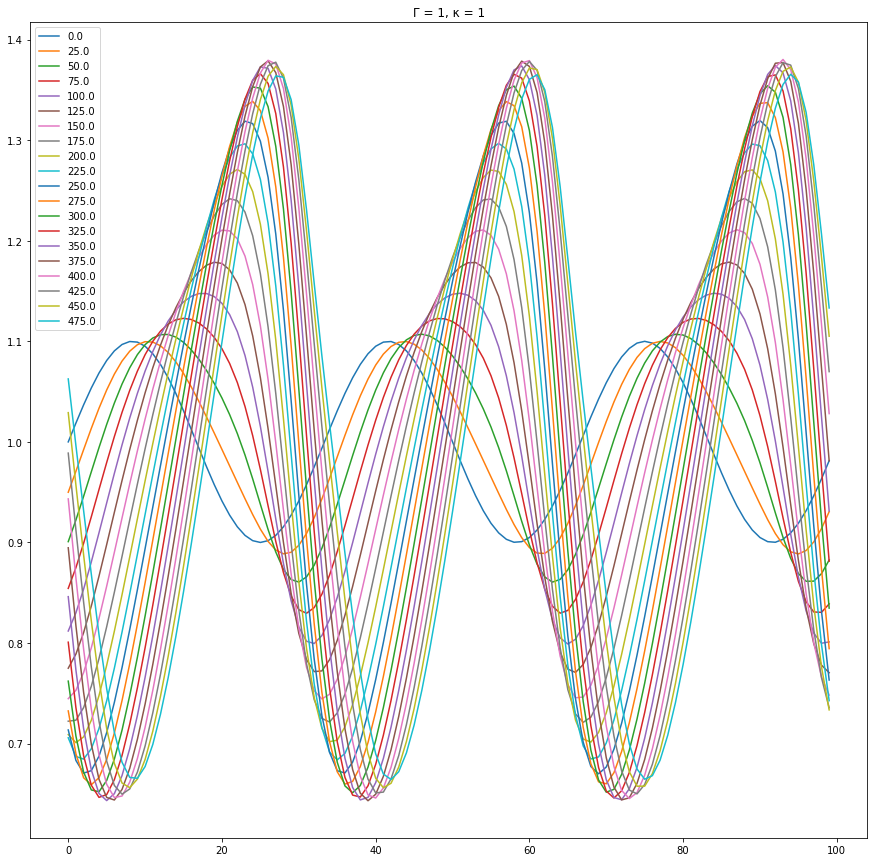

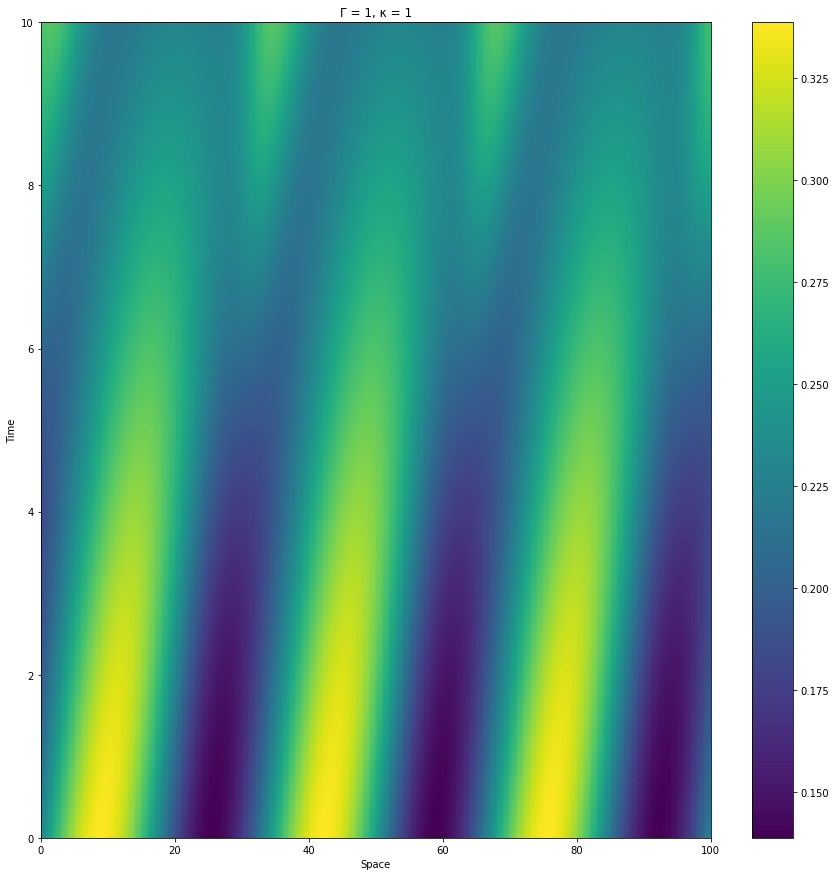

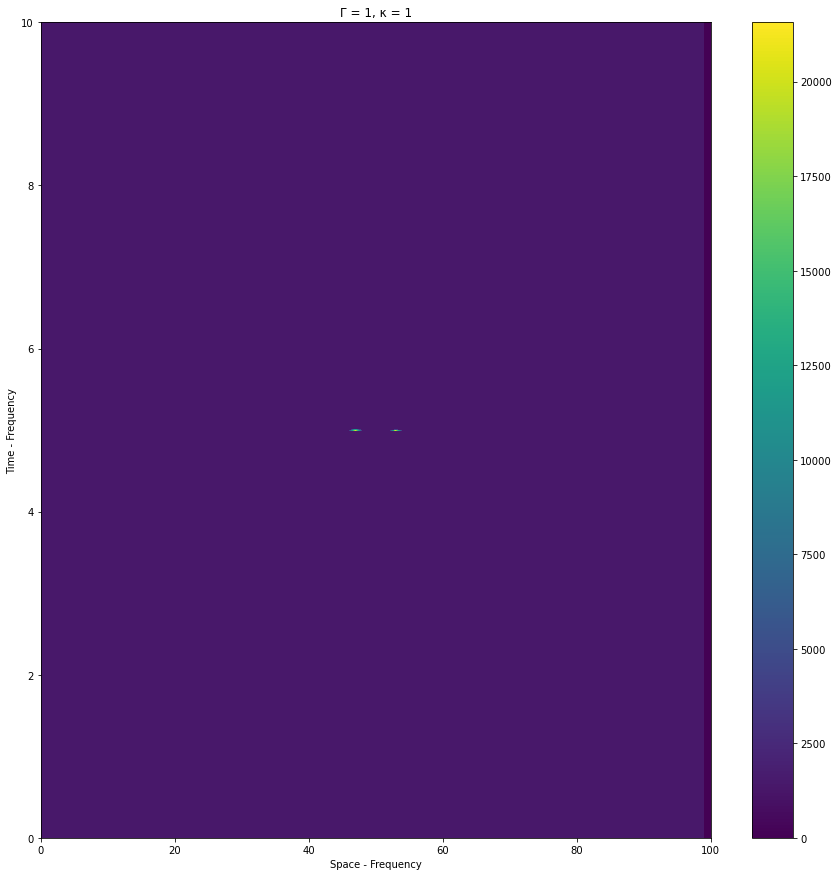

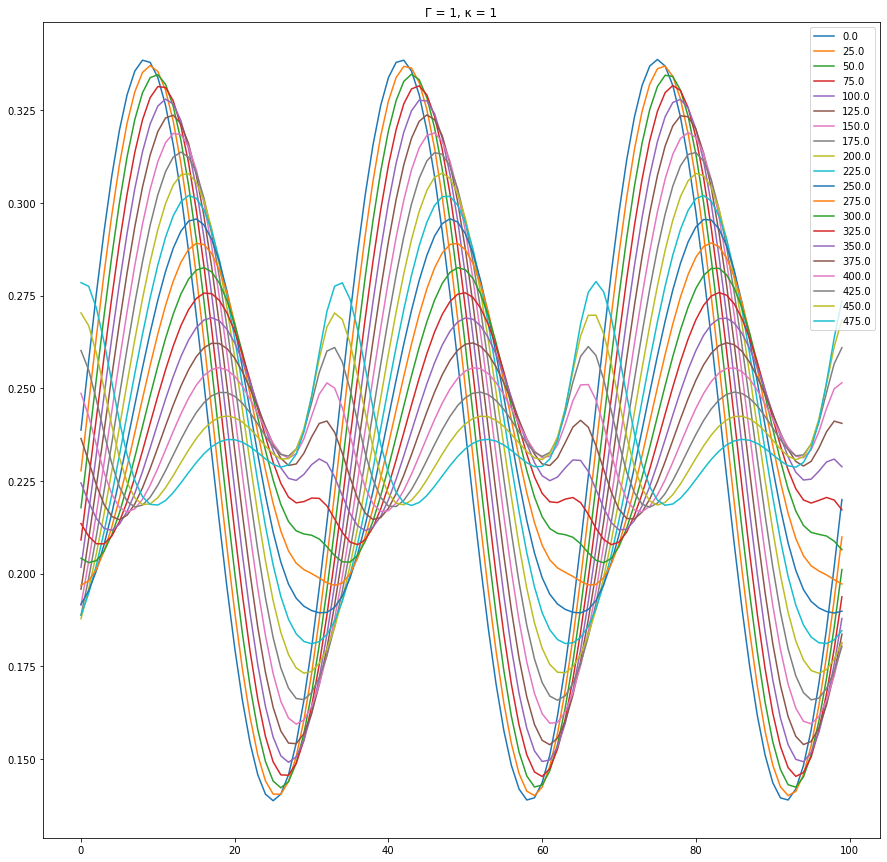

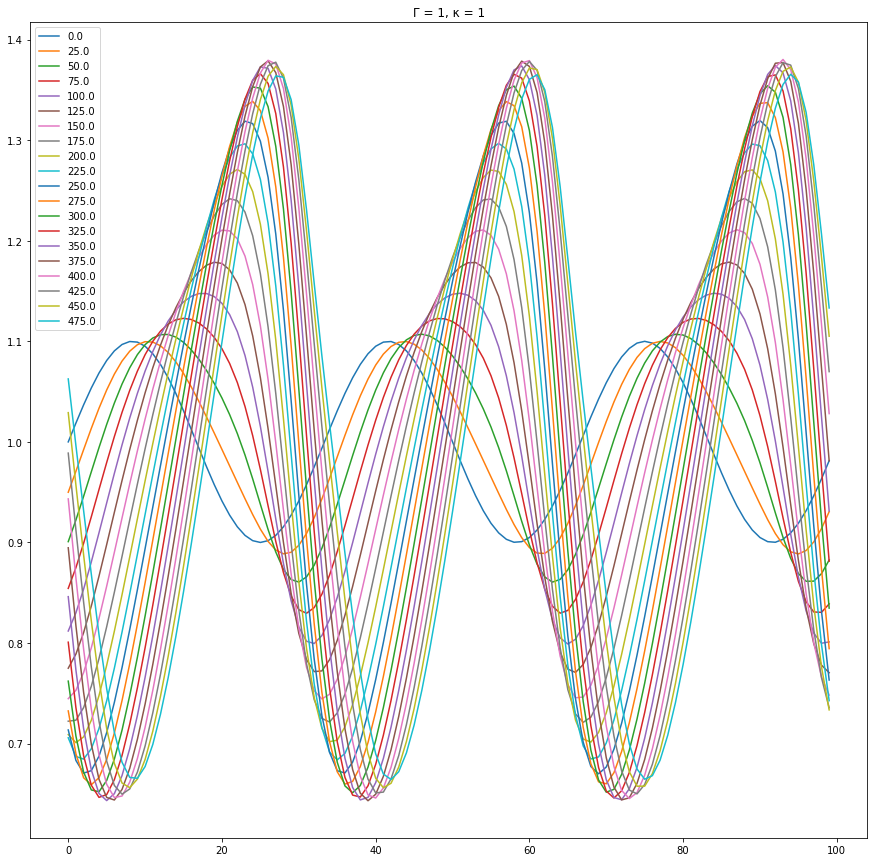

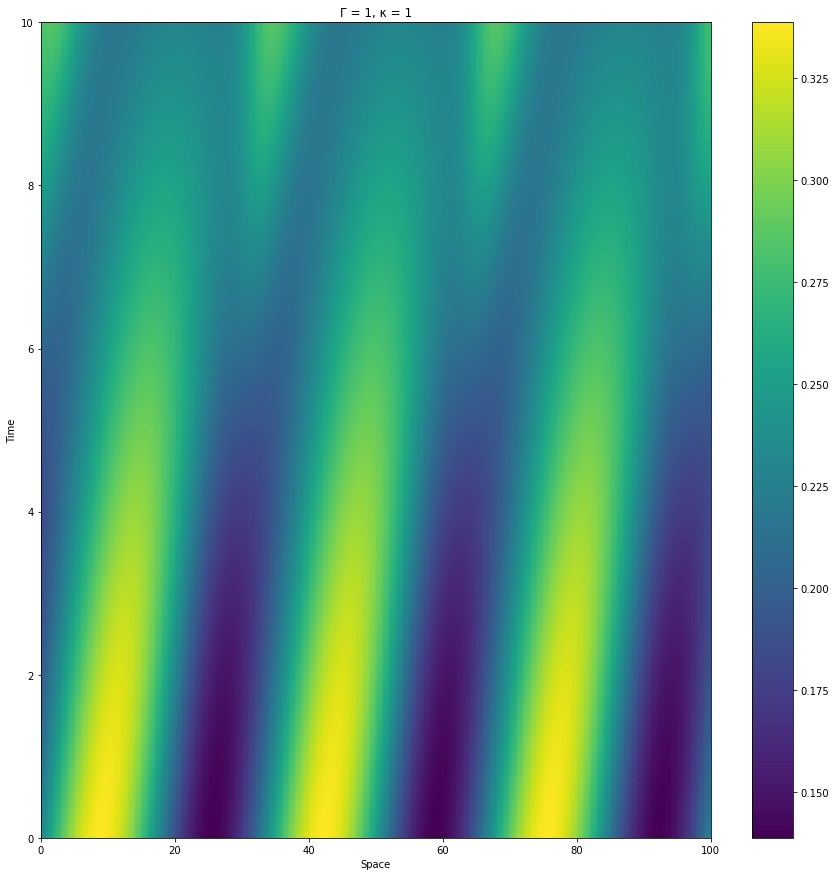

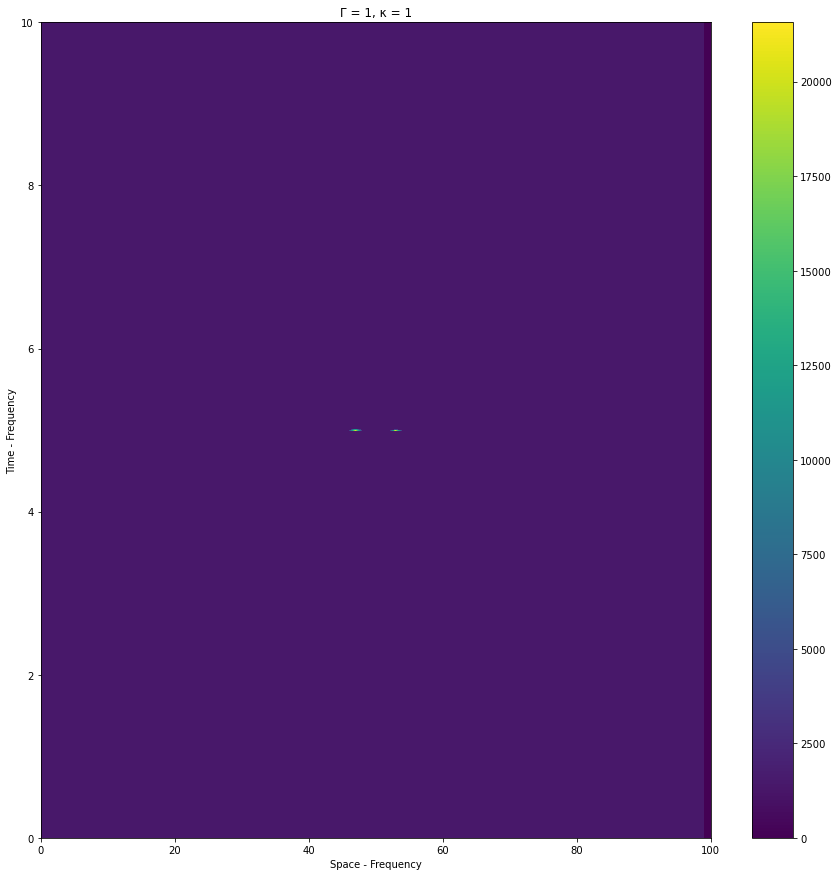

In [7]:
# ==== #
# Plot #
# ==== #

# plot(x[0:10],n[:,:,0:10])
print(lmbd)
plot(x,n[0]-n[1])
cmap(x,t,n[0]-n[1])
disp_rel_cmap(x,t,n[0]-n[1])
for c in range(2):
    plot(x,n[c])
    plot(x,v[c])
    cmap(x, t, n[c])
    disp_rel_cmap(x, t, n[c])

In [8]:
def subplot(u):
    fig, axes = plt.subplots(nrows=3, ncols=3)
    # find minimum of minima & maximum of maxima
    minmin = np.min(uc for uc in u)
    maxmax = np.max(uc for uc in u)
    for c in range(2):
        images = []
        for ii in range(3):
            for jj in range(3):
                im = axes[ii][jj].imshow(u[ii+jj], vmin=minmin, vmax=maxmax,
                                         extent=(X0,Xf,T0,Tf), aspect='auto', cmap='viridis')
                axes[ii][jj].set_title('Γ = ' + str(Gamma[ii]) + ', κ = ' + str(kappa[jj]))
                axes[ii][jj].set_ylabel("Time")
                axes[ii][jj].set_xlabel("Space")
                images.append(im)

        fig.tight_layout(pad = .01)
        fig.subplots_adjust(top=0.9)
        fig.suptitle("Density: Xptso Correlations")
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=1)
        plt.show(block=False)
    